## 2.  Redes recurrentes sobre texto
Hoy en dı́a, una aplicación relevante de las redes neuronales recurrentes es el modelamiento de texto y lenguaje natural. En esta sección abordaremos el problema de procesar sentencias de texto proporcionadas por GMB (*Groningen Meaning Bank*) para reconocimiento de entidades y tagger. Trabajaremos con el dataset proprocionado a través de la interfaz de Kaggle en el siguiente __[link](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus)__, con mas de un millón de palabras trabajaremos este dataset para realizar predicciones sobre distintas tareas, del tipo *many to many* y *many to one*.

<img src="https://i.stack.imgur.com/b4sus.jpg" width="70%" />

In [31]:
%matplotlib inline
import time
import operator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.core.pylabtools import figsize
from sklearn.model_selection import train_test_split

from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout, Bidirectional

plt.style.use('ggplot')

In [2]:
file = "./entity-annotated-corpus/ner.csv.zip"
df_ner = pd.read_csv(file, compression="infer", error_bad_lines=False, encoding="Latin-1")
df_ner.dropna(inplace=True) 

b'Skipping line 281837: expected 25 fields, saw 34\n'


In [3]:
df_ner.head()

,Unnamed: 0,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,...,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,...,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,...,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,...,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,...,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,4,march,through,london,NNP,capitalized,London,IN,lowercase,through,...,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O


In [4]:
df_ner.shape

(1050794, 25)

In [5]:
df_ner.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1050794 entries, 0 to 1050794
Data columns (total 25 columns):
Unnamed: 0         1050794 non-null int64
lemma              1050794 non-null object
next-lemma         1050794 non-null object
next-next-lemma    1050794 non-null object
next-next-pos      1050794 non-null object
next-next-shape    1050794 non-null object
next-next-word     1050794 non-null object
next-pos           1050794 non-null object
next-shape         1050794 non-null object
next-word          1050794 non-null object
pos                1050794 non-null object
prev-iob           1050794 non-null object
prev-lemma         1050794 non-null object
prev-pos           1050794 non-null object
prev-prev-iob      1050794 non-null object
prev-prev-lemma    1050794 non-null object
prev-prev-pos      1050794 non-null object
prev-prev-shape    1050794 non-null object
prev-prev-word     1050794 non-null object
prev-shape         1050794 non-null object
prev-word          1050794 n

> a) En esta primera instancia trabajaremos con la tarea de realizar un POS *tag* (*Part of Speech*) sobre cada una de las palabras en las sentencias que se nos presenta en los datos, también puede intentar el NER (*Named Entity Recogntion*) sobre la columna *tag*, esta tarea es del tipo *many to many*, es decir, la entrada es una secuencia y la salida es una secuencia sin *shift*, por lo que necesitaremos una estructura de red adecuada a esto. En primer lugar extraiga las columnas que utilizaremos del dataset ¿Por qué es conveniente utilizar *lemma* en vez de la palabra misma *word*?

In [6]:
dataset = df_ner.loc[:,["lemma","pos","tag","prev-iob"]]

In [7]:
dataset.head()

,lemma,pos,tag,prev-iob
0,thousand,NNS,O,__START1__
1,of,IN,O,O
2,demonstr,NNS,O,O
3,have,VBP,O,O
4,march,VBN,O,O


Luego de esto cree una estructura que contendrá todas las sentencias u oraciones y otra estructura que contendrá los pos tagger, esto es un arreglo de arreglos de lemmas y un arreglo de arreglos de tags respectivamente. ¿Cuales son las dimensiones de ambas estructuras? ¿Cada dato de ejemplo tiene las mismas dimensiones que el resto?

In [8]:
sentence = []
labels_sentence = []
dataX,dataY = [],[]
#uniques
lemmas,labels = set(), set()

for fila in dataset.values:
    if fila[-1]=="__START1__": 
        dataX.append(np.asarray(sentence))
        dataY.append(np.asarray(labels_sentence))
        sentence = []
        labels_sentence = []
    lemmas.add(fila[0])
    labels.add(fila[1])
    sentence.append(fila[0])#add lemma
    labels_sentence.append(fila[1]) #POS o TAG
#data to  array
dataX = np.asarray(dataX[1:])
dataY = np.asarray(dataY[1:])

In [9]:
print("Cantidad labels: ", len(labels))
print("Cantidad lemmas: ", len(lemmas))
print("Tamaño matriz de lemmas: ", dataX.shape)
print("Tamaño matriz de labels: ", dataY.shape)

Cantidad labels:  41
Cantidad lemmas:  20243
Tamaño matriz de lemmas:  (48081,)
Tamaño matriz de labels:  (48081,)


> b) Estudie la distribución del largo de los textos a procesar. Estudie también la frecuencia con la que aparecen
las palabras en todo el dataset. ¿Se observa una ley Zipf? ¿Cambia el resultado cuando se separan los textos de acuerdo a su clase/categorı́a? Comente.

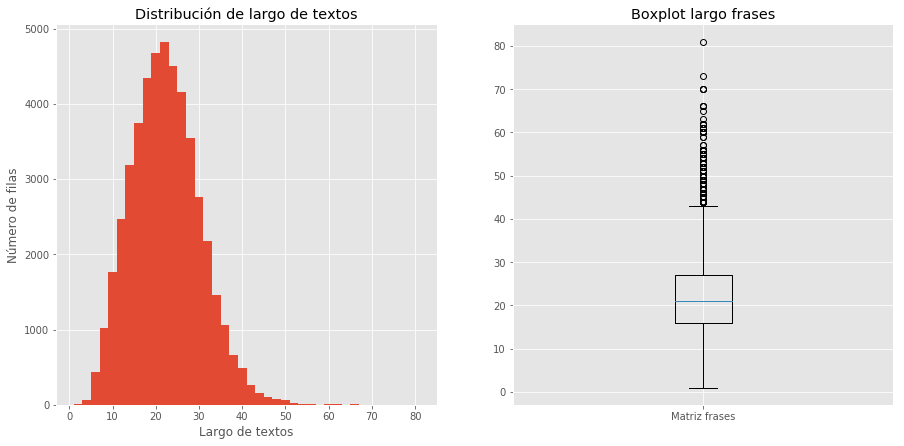

In [10]:
phrases_len = []
for row in dataX:
    phrases_len.append(len(row))

figsize(15,7)
plt.subplot(121)
plt.hist(phrases_len, bins=40)
plt.xlabel("Largo de textos")
plt.ylabel("Número de filas")
plt.title("Distribución de largo de textos")

plt.subplot(122)
plt.boxplot(phrases_len, labels=["Matriz frases"])
plt.title("Boxplot largo frases")
plt.show()

In [11]:
def get_frequency(data):
    words = dict()
    for phrase in data:
        for word in phrase:
            if word not in words:
                words[word] = 0
            words[word] += 1
    words = sorted(words.items(), key=operator.itemgetter(1), reverse=True)
    return words

words_freq = get_frequency(dataX)
lemmas_freq = get_frequency(dataY)

w, w_freq = zip(*words_freq)
l, l_freq = zip(*lemmas_freq)

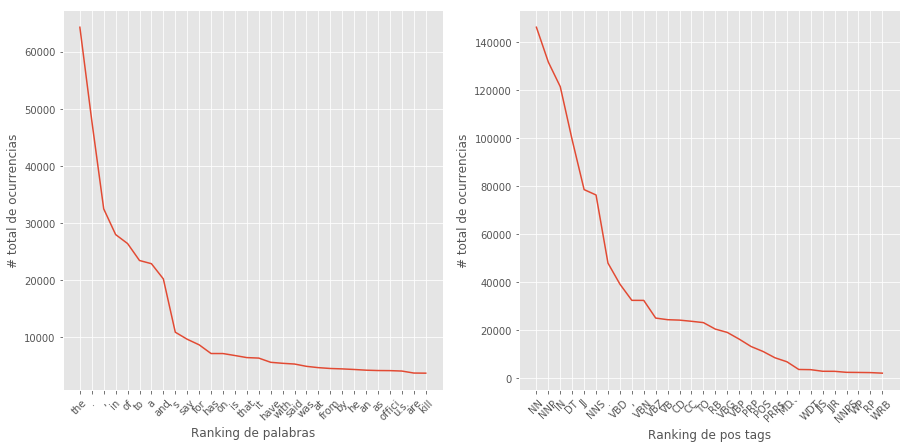

In [12]:
x_ = np.arange(30)
plt.subplot(121)
plt.plot(x_, w_freq[:30])
plt.xticks(x_, w[:30], rotation=45)
plt.xlabel("Ranking de palabras")
plt.ylabel("# total de ocurrencias")

plt.subplot(122)
plt.plot(x_, l_freq[:30])
plt.xticks(x_, l[:30], rotation=45)
plt.xlabel("Ranking de pos tags")
plt.ylabel("# total de ocurrencias")
plt.show()

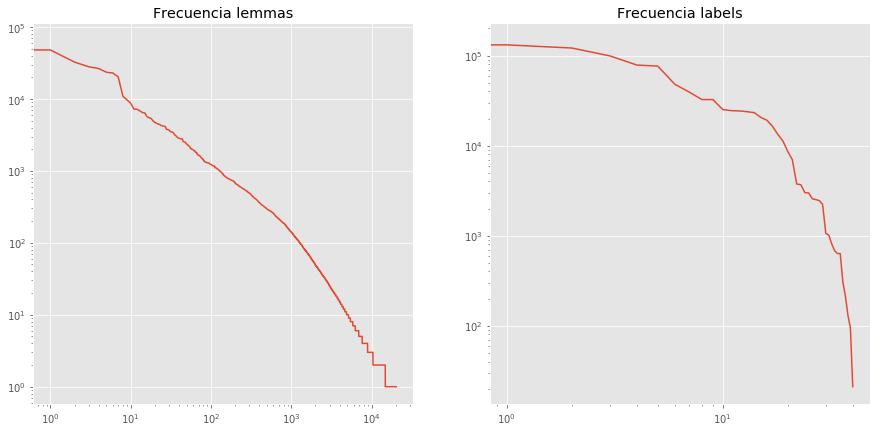

In [13]:
plt.subplot(121)
plt.loglog(np.arange(len(w)), w_freq)
plt.title("Frecuencia lemmas")
plt.subplot(122)
plt.loglog(np.arange(len(l)), l_freq)
plt.title("Frecuencia labels")
plt.show()

> c) Es necesario transformar los textos para que puedan ser entregados apropiadamente a la red, por lo será necesario crear una función que codifique cada posible *lemma* a un número y cada posible *tag* a otro número, utilice esta función sobre las sentencias y *tags* ya generados. Mida cual es el largo máximo de entre todas las sentencias, la cantidad de *lemmas* y etiquetas. Además de esto, debido al largo distinto de las sentencias se deberá realizar *padding* para estandarizar el largo, considere algun carácter especial para codificar el espacio en blanco que luego se le deberá rellenar, por ejemplo si el largo máximo es de 4 y se tiene la sentencia "the rocket" codificada como [32,4] será necesario agregar un *lemma* que codificado significará el fin de la sentencia "the rocket *ENDPAD ENDPAD*" y codificado quedará como [32,4,*0, 0*].

Primero determinamos el tamaño de la sentencia más larga.

In [14]:
max_len = 0
for lemma in dataX:
    max_len = max(len(lemma), max_len)
print("Tamaño sentencia más larga: ", max_len)

Tamaño sentencia más larga:  81


A su vez, se agrega el lemma *ENDPAD* que indica espacios en blancos en una sentencia, para dejarlas todas del mismo largo, y su correspondiente label *ENDP*.

In [15]:
lemmas.add("ENDPAD")
labels.add("ENDPAD")

Antes de hacer el cambio de palabras a índices, la primera sentencia es de la siguiente forma.

In [16]:
print(dataX[0])

['thousand' 'of' 'demonstr' 'have' 'march' 'through' 'london' 'to'
 'protest' 'the' 'war' 'in' 'iraq' 'and' 'demand' 'the' 'withdraw' 'of'
 'british' 'troop' 'from' 'that' 'countri' '.']


Así, se hace la conversión de lemmas y labels a números. dataX y dataY se cambian para contener sentencias con los índices de cada palabra.

In [17]:
lemma2idx = {w: i for i, w in enumerate(lemmas)} # Convertir texto a numeros
lab2idx = {t: i for i, t in enumerate(labels)} # Convertir labels a numeros
dataX = [[lemma2idx[lemma] for lemma in sentence ] for sentence in dataX]
dataY = [[lab2idx[pos] for pos in pos_tags ] for pos_tags in dataY]
n_lemmas = len(lemmas)
n_labels = len(labels)

Con el cambio, la primera sentencia queda como se muestra a continuación.

In [18]:
print(dataX[0])

[20, 2333, 9800, 11967, 6282, 18328, 821, 16690, 18258, 1479, 14372, 1784, 16054, 14432, 7413, 1479, 9050, 2333, 8475, 74, 2677, 17383, 17277, 8884]


In [19]:
X = sequence.pad_sequences(dataX, maxlen=max_len, padding="post", value=lemma2idx["ENDPAD"])
y = sequence.pad_sequences(dataY, maxlen=max_len, padding="post", value=lab2idx["ENDPAD"])

In [20]:
print(X[0])

[   20  2333  9800 11967  6282 18328   821 16690 18258  1479 14372  1784
 16054 14432  7413  1479  9050  2333  8475    74  2677 17383 17277  8884
 14980 14980 14980 14980 14980 14980 14980 14980 14980 14980 14980 14980
 14980 14980 14980 14980 14980 14980 14980 14980 14980 14980 14980 14980
 14980 14980 14980 14980 14980 14980 14980 14980 14980 14980 14980 14980
 14980 14980 14980 14980 14980 14980 14980 14980 14980 14980 14980 14980
 14980 14980 14980 14980 14980 14980 14980 14980 14980]


In [21]:
print(y[0])

[ 4  9  4 27 35  9  8 32 33 24 25  9  8 17 33 24 25  9 23  4  9 24 25 20
 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39
 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39
 39 39 39 39 39 39 39 39 39]


In [22]:
print(lemma2idx['ENDPAD'])
print(lab2idx['ENDPAD'])

14980
39


In [23]:
X.shape

(48081, 81)

> d) Realice el *padding* anteriormente mencionado, decida sobre qué le parece mas conveniente al rellenar con el valor especial ¿Al principio o al final de la sentencia? Comente

En el punto anterior se aplicó padding al final de las sentencias. Se prefiere dejar al final de la oración pues es fácil identificar la hubicación de la información, si esta está siempre al comienzo del arreglo, y a su vez es fácil identificar cuando esta termina con solo llegar a la etiqueta *ENDPAD*.

Dependiendo del dominio del problema puede ser más conveniente colocar en un lugar el padding en vez del otro.

> e) Para el poder entregar una clasificación sobre los distintos *pos tagger* es necesario tranformarlas a *one hot vectors*, debido a que están codificadas en números enteros, con esto se quedará con un arreglo tridimensional con la cantidad de ejemplos, la cantidad máxima de palabras y la cantidad de posibles *pos tags*. Luego de esto cree los conjuntos de entrenamiento y de prueba con el código a continuación ¿Cuáles son las dimensiones de entrada y salida de cada conjunto? Comente

In [24]:
print("Dimensión X sentencias: ", X.shape)
print("Dimensión y post tags : ", y.shape)

Dimensión X sentencias:  (48081, 81)
Dimensión y post tags :  (48081, 81)


In [25]:
y = np.asarray([to_categorical(i, num_classes=n_labels) for i in y])

In [26]:
y.shape

(48081, 81, 42)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=22)

In [28]:
print("Tamaño X_train: ", X_train.shape)
print("Tamaño y_train: ", y_train.shape)
print("Tamaño X_test : ", X_test.shape)
print("Tamaño y_test : ", y_test.shape)

Tamaño X_train:  (33656, 81)
Tamaño y_train:  (33656, 81, 42)
Tamaño X_test :  (14425, 81)
Tamaño y_test :  (14425, 81, 42)


> f) Defina una red neuronal recurrente *many to many* con compuertas LSTM para aprender a *tagear* el texto, entrenela y evalúe su desempeño sobre ambos conjuntos. Esta red debe procesar la secuencia de *lemmas* rellenados (o sin rellenar) y entregar el *pos tag* a cada uno de estos *lemmas*, por lo que la salida de la red no es un vector como anteriormente se ha trabajado, sino que tiene una dimensión extra la cual es debido a que en cada instante de tiempo se necesita entregar un *output*. Como los *lemmas* corresponden a datos esencialmente categóricos, o al menos discretos, es necesario generar una representación vectorial de ellas. La primera capa de la red a construir debe por lo tanto incluir una transformación entrenable desde el espacio de representación original (discreto) a ${\rm I\!R}^{d}$ , con $d$ la dimensionalidad del *embedding*. Comente sobre los cambios que sufre un dato al ingresar a la red y la cantidad de parámetros de la red.

# agregar calculo de dimensión

In [40]:
embedding_vector = 32
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_len))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
results = model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=3, batch_size=128)
scores = model.evaluate(X_test, y_test, verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 81, 32)            647808    
_________________________________________________________________
lstm_2 (LSTM)                (None, 81, 100)           53200     
_________________________________________________________________
dense_2 (Dense)              (None, 81, 42)            4242      
Total params: 705,250
Trainable params: 705,250
Non-trainable params: 0
_________________________________________________________________


/home/nacho/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 33656 samples, validate on 14425 samples
Epoch 1/3
33656/33656 [==============================] - 52s 2ms/step - loss: 1.0717 - acc: 0.7491 - val_loss: 0.7590 - val_acc: 0.7935
Epoch 2/3
33656/33656 [==============================] - 50s 1ms/step - loss: 0.6029 - acc: 0.8372 - val_loss: 0.4029 - val_acc: 0.8881
Epoch 3/3
33656/33656 [==============================] - 51s 2ms/step - loss: 0.2690 - acc: 0.9294 - val_loss: 0.1811 - val_acc: 0.9526


In [41]:
print("Loss: %.4f\tAccuracy: %.4f" % (scores[0], scores[1]))

Loss: 0.1811	Accuracy: 0.9526


Se tiene un buen desempeño de la red con un 95.3% de accuracy.

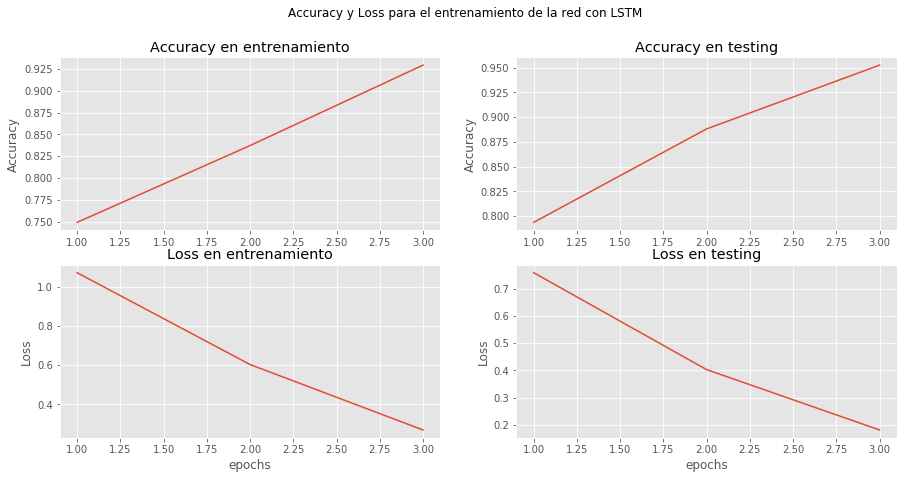

In [65]:
plt.suptitle("Accuracy y Loss para el entrenamiento de la red con LSTM")
plt.subplot(221)
plt.plot(range(1,4), results.history['acc'])
plt.ylabel('Accuracy')
plt.title('Accuracy en entrenamiento')
plt.subplot(222)
plt.plot(range(1,4), results.history['val_acc'])
plt.ylabel('Accuracy')
plt.title('Accuracy en testing')
plt.subplot(223)
plt.plot(range(1,4), results.history['loss'])
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.title('Loss en entrenamiento')
plt.subplot(224)
plt.plot(range(1,4), results.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.title('Loss en testing')
plt.show()

> g) Varı́e la dimensionalidad del embedding inicial y determine si aumenta o disminuye el error de clasificación. Comente.

In [25]:
score_models = {}
times = {}
embedding_vectors = [16, 32, 42, 64, 81, 128, 256]
for size in embedding_vectors:
    print("---- Dimensión Embedding %d ----" % size)
    model = Sequential()
    model.add(Embedding(input_dim=n_lemmas, output_dim=size, input_length=max_len))
    model.add(LSTM(units=100,return_sequences=True))
    model.add(Dense(n_labels, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    start_time = time.time()
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)
    duration = time.time()-start_time
    print("Tiempo embeding {} : {}".format(size, duration))
    score_models[size] = model.evaluate(X_test, y_test, verbose=0)
    times[size] = duration

---- Dimensión Embedding 16 ----
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 81, 16)            323904    
_________________________________________________________________
lstm_1 (LSTM)                (None, 81, 100)           46800     
_________________________________________________________________
dense_1 (Dense)              (None, 81, 42)            4242      
Total params: 374,946
Trainable params: 374,946
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/3
33656/33656 [==============================] - 45s 1ms/step - loss: 1.1094 - acc: 0.7407 - val_loss: 0.7905 - val_acc: 0.7764
Epoch 2/3
33656/33656 [==============================] - 43s 1ms/step - loss: 0.7123 - acc: 0.8079 - val_loss: 0.5857 - val_acc: 0.8478
Epoch 3/3
33656/33656 [======================

Train on 33656 samples, validate on 14425 samples
Epoch 1/3
33656/33656 [==============================] - 65s 2ms/step - loss: 0.8576 - acc: 0.8012 - val_loss: 0.3643 - val_acc: 0.9100
Epoch 2/3
33656/33656 [==============================] - 66s 2ms/step - loss: 0.1795 - acc: 0.9553 - val_loss: 0.1090 - val_acc: 0.9686
Epoch 3/3
33656/33656 [==============================] - 66s 2ms/step - loss: 0.0862 - acc: 0.9738 - val_loss: 0.0834 - val_acc: 0.9737
Tiempo embeding 256 : 198.1886179447174


In [30]:
# imprimir errores y tiempo
for size in embedding_vectors:
    print("E.V: %d,\t Acc: %.3f\tLoss: %.3f\tTime:%.1f" %
          (size, score_models[size][1], score_models[size][0], times[size]))

E.V: 16,	 Acc: 0.905	Loss: 0.336	Time:130.6
E.V: 32,	 Acc: 0.954	Loss: 0.184	Time:126.3
E.V: 42,	 Acc: 0.961	Loss: 0.152	Time:135.7
E.V: 64,	 Acc: 0.966	Loss: 0.122	Time:139.9
E.V: 81,	 Acc: 0.968	Loss: 0.111	Time:150.1
E.V: 128,	 Acc: 0.971	Loss: 0.099	Time:161.0
E.V: 256,	 Acc: 0.974	Loss: 0.083	Time:198.2


> h) Use Dropout para entrenar la LSTM. ¿El Dropout mejora el desempeño de la red? Señale cuales podrı́an ser las causas del comportamiento observado.

In [29]:
#from keras.layers import Dropout
embedding_vector = 32
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_len))
model.add(LSTM(units=100,return_sequences=True)) #or recurrent_dropout=0.2
model.add(Dropout(0.2))
model.add(Dense(n_labels, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
start_time = time.time()
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)
duration = time.time() - start_time
score = model.evaluate(X_test, y_test, verbose=0)

Train on 33656 samples, validate on 14425 samples
Epoch 1/3
33656/33656 [==============================] - 53s 2ms/step - loss: 1.0850 - acc: 0.7464 - val_loss: 0.7700 - val_acc: 0.7864
Epoch 2/3
33656/33656 [==============================] - 47s 1ms/step - loss: 0.6621 - acc: 0.8186 - val_loss: 0.4628 - val_acc: 0.8764
Epoch 3/3
33656/33656 [==============================] - 46s 1ms/step - loss: 0.3286 - acc: 0.9119 - val_loss: 0.2030 - val_acc: 0.9478


In [30]:
print(hist.history)
print("Loss: %.3f\tAccuracy: %.3f\tTiempo: %.2f" % (score[0], score[1],duration))

{'val_loss': [0.7699954381683257, 0.46284172251691436, 0.20295822277949216], 'val_acc': [0.7864253145404664, 0.8764490662868969, 0.9478391836462235], 'loss': [1.0850297167546568, 0.6621341074705974, 0.32860888824812556], 'acc': [0.7463908620853449, 0.8185710452757342, 0.9118558287847232]}
Loss: 0.203	Accuracy: 0.948	Tiempo: 147.57


> i) Algunos autores señalan la importante dependencia que existe en texto, no solo con las palabras anteriores, sino que con las que siguen. Mejore la red definida en f) utilizando una red neuronal recurrente Bidireccional, es decir, con recurrencia en ambas direcciones sobre la secuencia de *lemmas* de entrada. Comente cuál debiera ser la forma correcta de usar el parámetro *merge_mode* (concatenar, multiplicar, sumar o promediar) para este caso. Además comente las transformaciones que sufre el patrón de entrada al pasar por las capas. ¿Mejora o empeora el desempeño? Analice.


In [ ]:
from keras.layers import Bidirectional
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_input_lenght))
layer_lstm = LSTM(units=100,return_sequences=True)
model.add(Bidirectional(layer_lstm,merge_mode=choose))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=3, batch_size=128)

> j) Utilice alguna de las red entrenadas, ojalá una con buen desempeño y muestre las predicciones, el *pos tager*, sobre algún ejemplo de pruebas, comente. Para entender qué son los símbolos *Part of speech tags* visite el siguiente link: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html 


In [ ]:
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
print("{:15}: {}".format("Lemma", "Pred"))
for w,pred in zip(X_test[i],p[0]):
    print("{:15}: {}".format(lemmas[w],labels[pred]))

> k) Carge las palabras del dataset ¿Por qué no los *lemmas*? y cree el corpus con el cual se trabajará, además de crear la codificación de caracteres a números. Esto se presenta en el código a continuación además de crear la estrucutura de los datos con los que se va a trabajar (sub sentencias del corpus original). Utilice el tamaño del *corpus* que le acomode a la memoria de su computador.

In [ ]:
dataset = df_ner.loc[:,["word","lemma"]]
text = ' '.join(dataset["word"]).lower() #corpus
null_character = "*"
chars = [null_character]+sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = {c: i for i, c in enumerate(chars)}
indices_char = {i: c for i, c in enumerate(chars)}
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 5 
sentences = []
next_chars = []
size = int(len(text)*0.2) #solo un 20% del corpus
for i in range(0, size - maxlen, step):
    sentences.append(null_character+text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

> l) Procese las sentencias para así tenerlas codificadas en números que van a representar los carácteres, tal cual se realizó en c) con los *lemmas*, lo mismo para las etiquetas. Además de esto deberá realizar el *padding* correspondiente al comienzo de la sentencia, esto es para que la red aprenda cuando venga una frase mas corta de lo entrenado, este símbolo siignificará que no hay información. Transforme las etiquetas a *one hot vector* como se realizó en c) y defina la red similar a la presentada en f), con un *embedding* seguido de una capa recurrente GRU y la capa de clasificación. Aprovechese de la implementación más rápida de GRU respaldada por __[CuDNN](https://developer.nvidia.com/cudnn)__, una librería de CUDA (NVIDIA) para *Deep Neural Network*. 

In [ ]:
dataX = [[char_indices[char] for char in sentence ] for sentence in sentences]
dataY = [char_indices[char] for char in next_chars]
...#dataX pad sequence padding='pre'
...#dataY to categorical with num_classes=len(chars)
from keras.layers import CuDNNGRU,GRU
embedding_vector = 16
model = Sequential()
model.add(Embedding(input_dim=len(chars), output_dim=embedding_vector, input_length=maxlen+1))#
model.add(CuDNNGRU(units=512,return_sequences=False)) #or GRU
model.add(Dropout(0.2))
model.add(Dense(len(chars), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

>  m) Entrene la red con las funciones que se presentan a continuación que mostrarán el cómo va la tarea de autocompletar texto en cada *epoch*, generando una sentencia completa de 400 carácteres *aleatoriamente* a partir de una semilla *random*. Entrene solo durante 25 *epochs*, a los 15 ya debería comenzar a generar palabras y sonar mas coherente.

In [ ]:

def predict_next_char(model, sentence, diversity=1.0):
    """Predict the next character from the current one"""    
    x_pred = [char_indices[null_character]]+[char_indices[char] for char in sentence]
    x_pred = sequence.pad_sequences([x_pred], maxlen=maxlen+1,padding='pre',value=char_indices[null_character])
    preds = model.predict(x_pred, verbose=0)[0]
    next_index = np.random.choice(len(chars), p=preds)
    return indices_char[next_index]
import random,sys
def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    print('\n----- Generating text after Epoch: %d' % epoch)
    start_index = random.randint(0, size - maxlen - 1)
    sentence = text[start_index: start_index + maxlen]
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(sentence)
    for i in range(400):
        next_char = predict_next_char(model, sentence0)
        sentence = sentence[1:] + next_char #for next character
        sys.stdout.write(next_char)
        sys.stdout.flush()
    return
from keras.callbacks import LambdaCallback
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
model.fit(X, y,batch_size=256,epochs=25, callbacks=[print_callback])


> n) Verifique la calidad de la red entrenada, cargando el modelo si es que lo guardó o directamente, entregando una predicción sobre una semilla inicial que usted entregue. Observe y comente cualitativamente sobre qué pasa cuando la predicción del siguiente carácter fuese de manera determinista, tomando el máximo valor de entre las predicciones.


In [ ]:

sentence = "it is "
print('----- Generating with seed: "' + sentence + '"')
sys.stdout.write(sentence)
for i in range(400):
    next_char = predict_next_char(model, sentence)
    sentence = sentence[1:] + next_char 
    sys.stdout.write(next_char)
    sys.stdout.flush()